In [2]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def loadlabels(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n = struct.unpack(">ll", f.read(2*4))
        assert(_magic == 2049)
        return np.frombuffer(f.read(n), dtype=np.dtype("B"))

def loadimages(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n, sx, sy = struct.unpack(">llll", f.read(4*4))
        assert(_magic == 2051)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, sx*sy).astype(np.float64)/255.0
        return ((sx, sy), images)

def load(labelsfp, imagesfp):
    labels = loadlabels(labelsfp)
    size, images = loadimages(imagesfp)
    assert(labels.shape[0] == images.shape[0])
    return (size, labels, images)

In [4]:
ddir = "data/digits/"
print("loading train set")
imgsize, train_labels, train_images = load(ddir + "train-labels-idx1-ubyte.gz", ddir + "train-images-idx3-ubyte.gz")

print("loading test set")
_imgsize, test_labels, test_images = load(ddir + "t10k-labels-idx1-ubyte.gz", ddir + "t10k-images-idx3-ubyte.gz")

assert(imgsize == _imgsize)

loading train set
loading test set


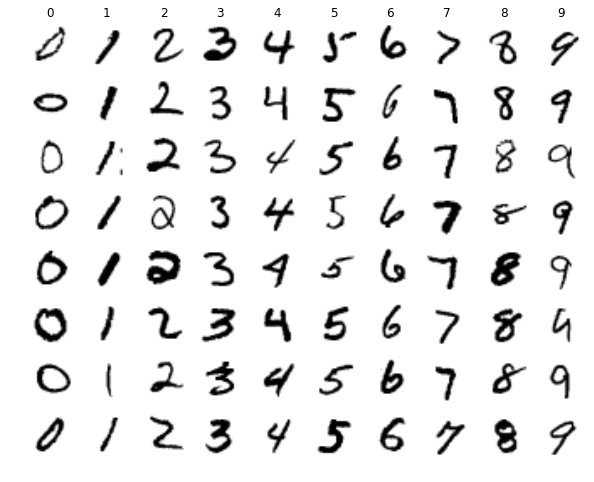

In [5]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(test_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - test_images[idx].reshape(*imgsize)))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

In [6]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [7]:
class FFNet(Net):
    def __init__(self, sizes):
        self.sizes = sizes
        layers = [n for sx, sy in zip(sizes[:-1], sizes[1:]) for n in [Affine(sx, sy), Bias(sy), ReLU()]][:-1]
        links = [(i - 1, i) for i in range(len(layers))] + [(len(layers) - 1, -1)]
        super().__init__(layers, links)

## Digit classification

In [8]:
class History:
    def __init__(self):
        self.t = []
        self.acc = []
        self.loss = []
        
    def append(self, t, acc, loss):
        self.t.append(t)
        self.acc.append(acc)
        self.loss.append(loss)

In [9]:
def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train.t, train.loss, label="Train loss: %.4f" % train.loss[-1])
    plt.plot(test.t, test.loss, label="Test loss: %.4f" % test.loss[-1])
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train.t, train.acc, label="Train accuracy: %.2f%%" % (100.0*(1.0 - train.acc[-1])))
    plt.plot(test.t, test.acc, label="Test accuracy: %.2f%%" % (100.0*(1.0 - test.acc[-1])))
    plt.yscale("log")
    plt.title("Error")
    plt.legend()
    
    plt.show()

In [10]:
batch_size = 100
solver = Solver(
    net=FFNet((imgsize[0]*imgsize[1], 100, 10)), loss=Softmax(),
    optims=[Adam(learn_rate=1e-3), Reg(1e-4)],
)

In [11]:
pos = 0
epoch = 0
train_history, test_history = History(), History()
train_loss = np.log(10)*(train_labels.shape[0]//batch_size)
train_hits = 0

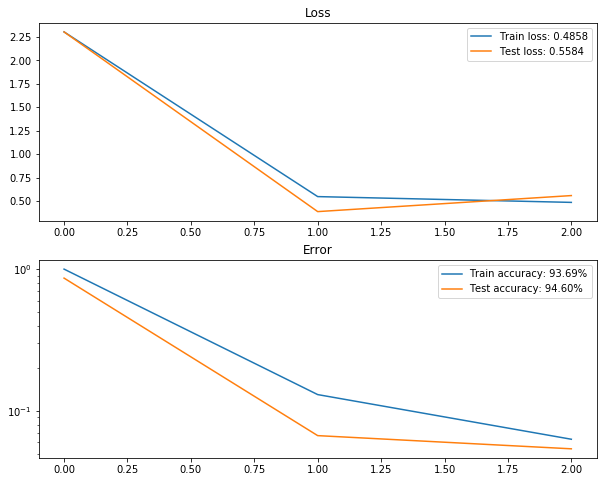

In [12]:
stop_on_signal()
while not signal_done:
    if pos == 0:
        train_history.append(
            epoch, 
            1.0 - train_hits/train_labels.shape[0], 
            train_loss/(train_labels.shape[0]//batch_size)
        )
        
        y, test_loss = solver.sample(test_images, test_labels)
        test_history.append(
            epoch, 
            1.0 - np.sum(np.equal(np.argmax(y, axis=-1), test_labels))/test_labels.shape[0],
            test_loss
        )
        
        train_loss = 0.0
        train_hits = 0
        _train_labels, _train_images = shuffle_sync([train_labels, train_images])
        
        clear_output(wait=True)
        plot(train_history, test_history)
        
        
    labels = _train_labels[pos:pos+batch_size]
    images = _train_images[pos:pos+batch_size]
    y, loss, _ = solver.learn(images, labels)
    train_hits += np.sum(np.equal(np.argmax(y, axis=-1), labels))
    train_loss += loss
    
    pos += batch_size
    if pos >= train_labels.shape[0]:
        pos = 0
        epoch += 1

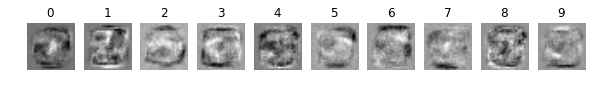

In [13]:
images = np.random.random((10, imgsize[0]*imgsize[1]))*1e-2
labels = np.arange(10)
for i in range(1000):
    y, _, cache = solver.forward(images, labels)
    dx, _ = solver.backward(cache)
    images -= 1e-2*dx
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(255.0*(1.0 - images[i].reshape(*imgsize)))
    plt.axis('off')
    plt.title(i)
plt.show()

## Image compression

In [14]:
class History:
    def __init__(self):
        self.t = []
        self.loss = []
        
    def append(self, t, loss):
        self.t.append(t)
        self.loss.append(loss)

In [15]:
def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train.t, train.loss, label="Train loss: %.4f" % train.loss[-1])
    plt.plot(test.t, test.loss, label="Test loss: %.4f" % test.loss[-1])
    plt.title("Loss")
    plt.legend()
    
    plt.show()

In [24]:
batch_size = 100
solver = Solver(
    net=FFNet((imgsize[0]*imgsize[1], 40, imgsize[0]*imgsize[1])), loss=RMS(),
    optims=[Adam(learn_rate=1e-4)],
)

In [25]:
pos = 0
epoch = 0
train_history, test_history = History(), History()
train_loss = 0.0

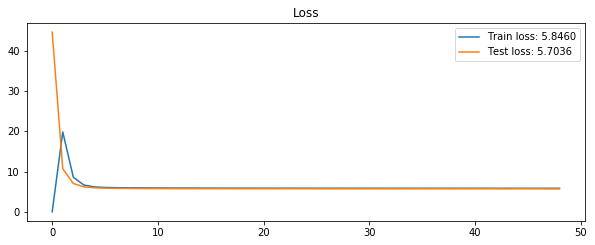

In [28]:
stop_on_signal()
while not signal_done:
    if pos == 0:
        train_history.append(
            epoch, 
            train_loss/(train_images.shape[0]//batch_size)
        )
        
        y, test_loss = solver.sample(test_images, test_images)
        test_history.append(
            epoch,
            test_loss
        )
        
        train_loss = 0.0
        _train_images = shuffle_sync([train_images])[0]
        
        clear_output(wait=True)
        plot(train_history, test_history)
    
    images = _train_images[pos:pos+batch_size]
    y, loss, _ = solver.learn(images, images)
    train_loss += loss
    
    pos += batch_size
    if pos >= train_images.shape[0]:
        pos = 0
        epoch += 1

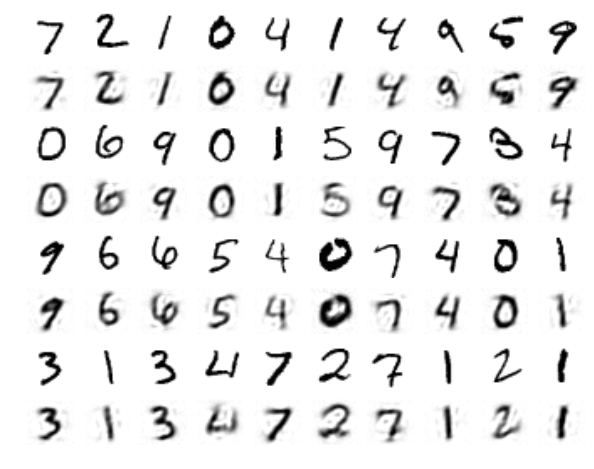

In [29]:
rows = 4

for r in range(rows):
    for i, image in enumerate(test_images[10*r:10*(r+1)]):
        plt.subplot(2*rows, 10, 10*2*r + i + 1)
        plt.imshow(255.0*(1.0 - image.reshape(*imgsize)))
        plt.axis('off')

        outimg = solver.sample(image.reshape(1, -1))[0]

        plt.subplot(2*rows, 10, 10*(2*r+1) + i + 1)
        plt.imshow(255.0*np.clip(1.0 - outimg.reshape(*imgsize), 0.0, 1.0))
        plt.axis('off')